# Submarine features generator (+tectonic faults model +submarine height model)

In [1]:
import numpy as np
import pandas as pd
from scipy import ndimage
from sklearn.metrics import accuracy_score
import random

from tqdm.notebook import tqdm
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
pd.set_option('display.max_columns', 500)

#Personal library for some machine learning alg. implementations
import myML
from numba import cuda

## Notes
Input must be the heightmap with water colored black RGB(0,0,0)

The algorithm takes exponentially longer to compute the bigger the sea gaps are. Trim them down if it's taking hours.

## Tectonic faults

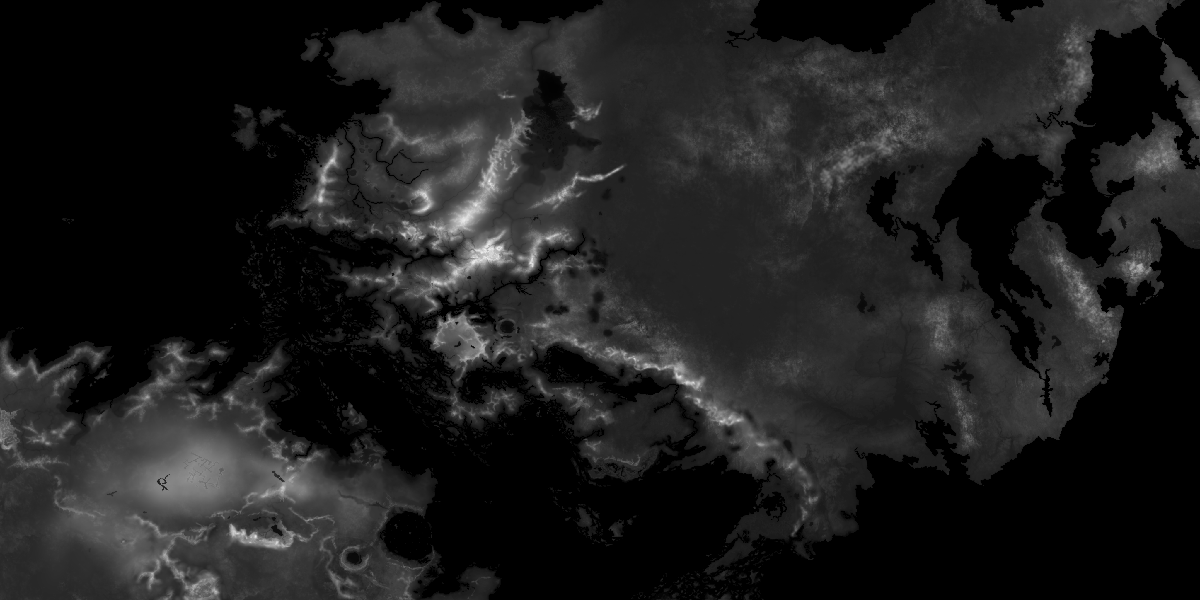

In [2]:
# Load (sea=black) (RGB 0,0,0) image in grayscale mode
imX = Image.open(r"input files/heightmap.png","r").convert('L')
display(imX.resize((1200,600), Image.Resampling.NEAREST))

#### Normalizing image to land>=129

In [3]:
imData = np.array(imX)
temp = np.min(imData[imData>0]), np.max(imData)
temp = ((imData-temp[0])/(temp[1]-temp[0])*96+129).astype(np.uint8)
for y0 in range(imData.shape[0]):
    for x0 in range(imData.shape[1]):
        if imData[y0,x0]>0:
            imData[y0,x0] = temp[y0,x0]

#### Building first two datasets

In [4]:
def radiusFinder(x0, imData, minPoints, limitradius):
    temp = []
    lims = imData.shape
    y0 = 0
    for r in range(10000):
        xlim = [max(0, x0-r), min(lims[1]-1, x0+r)]
        ylim = [max(0, y0-r), min(lims[0]-1, y0+r)]

        count = len(np.where(imData[ylim[0]:ylim[1]+1, xlim[0]:xlim[1]+1]>0)[0])
        
        if count>minPoints:
            temp.append(r)
            break

    for y0 in range(1,imData.shape[0]):
        r = temp[y0-1]-1
        if r>limitradius:
            xlim = [max(0, x0-r), min(lims[1]-1, x0+r)]
            ylim = [max(0, y0-r), min(lims[0]-1, y0+r)]
            if len(np.where(imData[ylim[0]:ylim[1]+1, xlim[0]:xlim[1]+1]>0)[0])>minPoints:
                temp.append(r)
                continue
        r+=1
        xlim = [max(0, x0-r), min(lims[1]-1, x0+r)]
        ylim = [max(0, y0-r), min(lims[0]-1, y0+r)]
        if len(np.where(imData[ylim[0]:ylim[1]+1, xlim[0]:xlim[1]+1]>0)[0])>minPoints:
            temp.append(r)
            continue
        else: temp.append(r+1)
        
    return temp

def inner_loop(x0, imData, adaptiveRadius, minPoints):
    temp = []
    lims = imData.shape
    res = np.sqrt(lims[0]**2+lims[1]**2)
    for y0 in range(imData.shape[0]):
        radius = adaptiveRadius[y0,x0]
        xlim = [max(0, x0-1-radius), min(lims[1]-1, x0+1+radius)]
        ylim = [max(0, y0-1-radius), min(lims[0]-1, y0+1+radius)]
        
        temp2 = np.where(imData[ylim[0]:ylim[1]+1, xlim[0]:xlim[1]+1]>0)
        landcount = len(temp2[0])
        watercount = (1+ylim[1]-ylim[0])*(1+xlim[1]-xlim[0])-landcount

        ranges = ylim[1]-ylim[0], xlim[1]-xlim[0]
        center = (y0-ylim[0])/ranges[0], (x0-xlim[0])/ranges[1]
        xlist, ylist = temp2[1]/ranges[1], temp2[0]/ranges[0]

        distances = np.linalg.norm([xlist-center[1],ylist-center[0]], axis=0)
        nearest = np.argsort(distances)[1:minPoints+1]
        mindist = np.sqrt(((xlist[nearest[1]]-center[1])*ranges[1])**2+((ylist[nearest[1]]-center[0])*ranges[0])**2)/res
        heights = [imData[ylim[0]+temp2[0][index],xlim[0]+temp2[1][index]] for index in nearest]
        x_train = np.concatenate(([watercount/(watercount+landcount), mindist], (xlist-center[1])[nearest], (ylist-center[0])[nearest], np.array(heights)))

        temp.append([x_train])

    return temp

In [5]:
convergent = 0
divergent = 255
water = 0
minPoints = 10
limitradius = (np.sqrt(minPoints)-1)/2

imData = np.array(imX)
adaptiveRadius = np.zeros_like(imX)
result = Parallel(n_jobs=-2)(delayed(radiusFinder)(x0, imData, minPoints, limitradius) for x0 in tqdm(range(imData.shape[1])))

adaptiveRadius = np.array(result).T

  0%|          | 0/4096 [00:00<?, ?it/s]

In [6]:
result = Parallel(n_jobs=-2)(delayed(inner_loop)(x0, imData, adaptiveRadius, minPoints) for x0 in tqdm(range(imData.shape[1])))

x_test = np.zeros((imData.shape[0]*imData.shape[1],minPoints*3+2))

count = 0
for x0 in result:
    for elem in x0:
        x_test[count,:] = elem[0]
        count+=1

x_test = pd.DataFrame(x_test,columns=['Water percent','Mindist']+[f'x{i}' for i in range(minPoints)]+[f'y{i}' for i in range(minPoints)]+[f'h{i}' for i in range(minPoints)])
x_test.head(3)

  0%|          | 0/4096 [00:00<?, ?it/s]

,Water percent,Mindist,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9
0,0.999923,0.169141,0.288204,0.284182,0.289544,0.285523,0.290885,0.286863,0.282842,0.292225,0.288204,0.284182,0.997319,0.998660,0.997319,0.998660,0.997319,0.998660,1.000000,0.997319,0.998660,1.000000,16.0,4.0,22.0,12.0,22.0,21.0,2.0,20.0,26.0,24.0
1,0.999923,0.168931,0.288591,0.284564,0.289933,0.285906,0.291275,0.287248,0.283221,0.292617,0.288591,0.284564,0.995979,0.997319,0.995979,0.997319,0.995979,0.997319,0.998660,0.995979,0.997319,0.998660,16.0,4.0,22.0,12.0,22.0,21.0,2.0,20.0,26.0,24.0
2,0.999923,0.168721,0.288978,0.284946,0.290323,0.286290,0.291667,0.287634,0.283602,0.293011,0.288978,0.284946,0.994638,0.995979,0.994638,0.995979,0.994638,0.995979,0.997319,0.994638,0.995979,0.997319,16.0,4.0,22.0,12.0,22.0,21.0,2.0,20.0,26.0,24.0


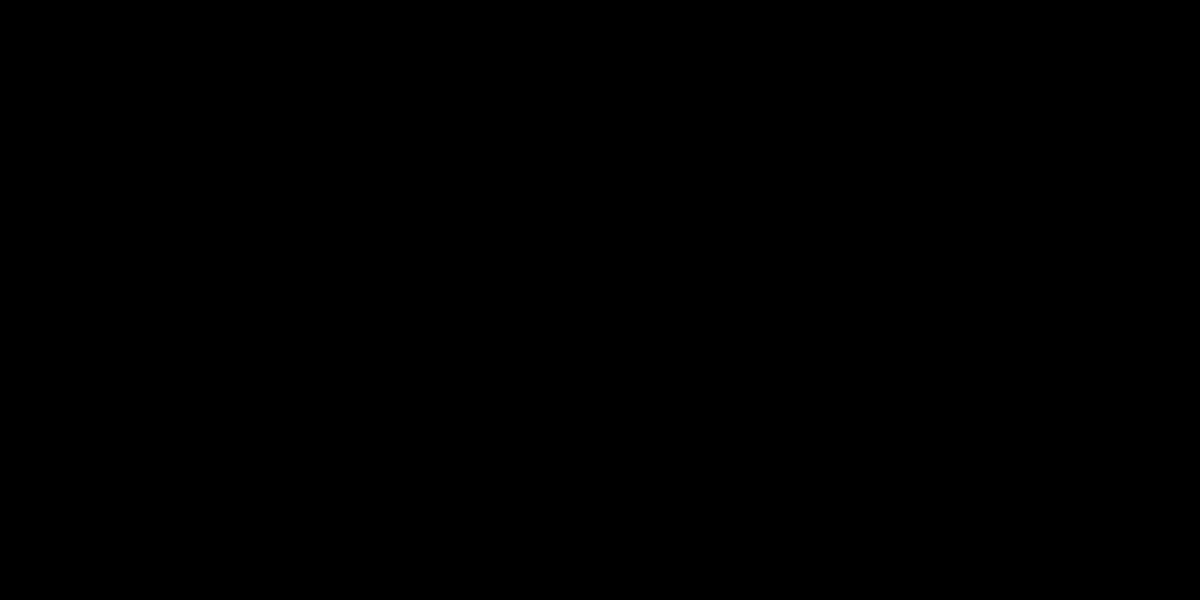

In [7]:
neuralnetwork = myML.ANN()
neuralnetwork.loadClass(name="training/faultmodel")
#neuralnetwork.defineNorm('Input', maximum=x_test.max(), minimum=x_test.min())

im = np.array(imX.copy())
points = neuralnetwork.run(x_test)
count = 0
for x in range(im.shape[1]):
    for y in range(im.shape[0]):
        temp = np.argmax(points[count,:])
        if temp==0: #Convergent
            im[y,x] = 0
        elif temp==1: #Divergent
            im[y,x] = 255
        else: im[y,x] = 128
        count+=1

im = Image.fromarray(im)
im.save('output files/step1.png')
display(im.resize((1200,600), Image.Resampling.NEAREST))

## Sea depth

In [8]:
def inner_loop(x0, imData, faults, water, radius):
    temp = []
    lims = imData.shape
    for y0 in range(imData.shape[0]):
        if imData[y0,x0]!=water: 
            temp.append([False])
            continue

        xlim = [max(0, x0-1-radius), min(lims[1]-1, x0+1+radius)]
        ylim = [max(0, y0-1-radius), min(lims[0]-1, y0+1+radius)]

        faulty = faults[ylim[0]:ylim[1]+1,xlim[0]:xlim[1]+1]
        x_train = [np.mean(faulty), np.std(faulty)]

        temp.append([x_train])

    return temp

In [9]:
water = 0
faults = np.array(im)/255

radius = int(np.ceil(np.sqrt(minPoints)))
result = Parallel(n_jobs=-2)(delayed(inner_loop)(x0, imData, faults, water, radius) for x0 in tqdm(range(imData.shape[1])))

x2_test = np.zeros((imData.shape[0]*imData.shape[1],2))
count = 0
count2 = 0
index = []
for x0 in result:
    for elem in x0:
        if elem[0] is not False:
            x2_test[count2,:] = elem[0]
            index.append(count)
            count2+=1
        count+=1

x2_test2 = x_test.loc[x_test.index.isin(index)].reset_index(drop=True)
x2_test2.insert(0,'Fault mean', x2_test[index,0]), x2_test2.insert(1,'Fault std', x2_test[index,1])
x2_test2.head(3)

  0%|          | 0/4096 [00:00<?, ?it/s]

,Fault mean,Fault std,Water percent,Mindist,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,h0,h1,h2,h3,h4,h5,h6,h7,h8,h9
0,0.0,0.0,0.999923,0.169141,0.288204,0.284182,0.289544,0.285523,0.290885,0.286863,0.282842,0.292225,0.288204,0.284182,0.997319,0.998660,0.997319,0.998660,0.997319,0.998660,1.000000,0.997319,0.998660,1.000000,16.0,4.0,22.0,12.0,22.0,21.0,2.0,20.0,26.0,24.0
1,0.0,0.0,0.999923,0.168931,0.288591,0.284564,0.289933,0.285906,0.291275,0.287248,0.283221,0.292617,0.288591,0.284564,0.995979,0.997319,0.995979,0.997319,0.995979,0.997319,0.998660,0.995979,0.997319,0.998660,16.0,4.0,22.0,12.0,22.0,21.0,2.0,20.0,26.0,24.0
2,0.0,0.0,0.999923,0.168721,0.288978,0.284946,0.290323,0.286290,0.291667,0.287634,0.283602,0.293011,0.288978,0.284946,0.994638,0.995979,0.994638,0.995979,0.994638,0.995979,0.997319,0.994638,0.995979,0.997319,16.0,4.0,22.0,12.0,22.0,21.0,2.0,20.0,26.0,24.0


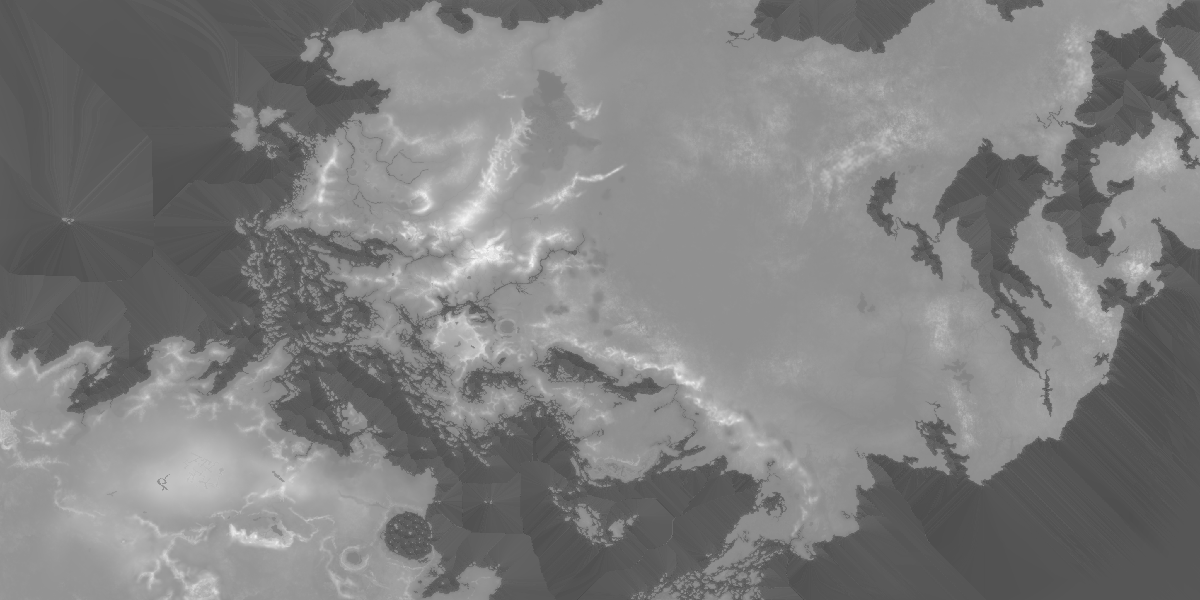

In [23]:
neuralnetwork = myML.ANN()
neuralnetwork.loadClass(name="training/heightmodel")

fullHeightmap = imData.copy()
points = neuralnetwork.run(x2_test2)
count = 0
for x in range(fullHeightmap.shape[1]):
    for y in range(fullHeightmap.shape[0]):
        if imData[y,x]!=water: 
            fullHeightmap[y,x] = np.uint8(imData[y,x]/255*128+127)#imData[y,x]
            continue
        fullHeightmap[y,x] = points[count,0]
        count+=1

imDepth = Image.fromarray(fullHeightmap)
imDepth.save('output files/step2.png')
display(imDepth.resize((1200,600), Image.Resampling.NEAREST))

## Mountain peaks

In [ ]:
# def peakFinder(x0, imData):
#     temp = []
#     lims = imData.shape
#     for y0 in range(imData.shape[0]):
#         xlim = [max(0, x0-1), min(lims[1]-1, x0+1)]
#         ylim = [max(0, y0-1), min(lims[0]-1, y0+1)]

#         color = imData[y0,x0]
#         color = color-2 if color<127 else color*0.99

#         count = len(np.where(imData[ylim[0]:ylim[1]+1,xlim[0]:xlim[1]+1]>color)[0])
#         if count<=2.2: temp.append(255)
#         else: temp.append(0)

#     return temp

# heighttemp = np.array(Image.fromarray(fullHeightmap).resize((600,300)))
# peakData = np.empty_like(heighttemp)
# result = Parallel(n_jobs=-2)(delayed(peakFinder)(x0, heighttemp) for x0 in tqdm(range(heighttemp.shape[1])))

# for x0, res in enumerate(result):
#     for y0, value in enumerate(res):
#         peakData[y0,x0] = value

# Image.fromarray(peakData).save('output files/step3.png')
# display(Image.fromarray(peakData).resize((1200,600), Image.Resampling.NEAREST))

In [ ]:
def peakFinder(x0, imData):
    temp = []
    lims = imData.shape
    for y0 in range(imData.shape[0]):
        color = imData[y0,x0]
        if color>=127:
            temp.append(255)
            continue

        count = 0
        sum = []
        for x1 in range(-1,2,1):
            x2 = x0+x1
            if x2<0 or x2>=lims[1]: continue
            for y1 in range(-1,2,1):
                if x1==0 and y1==0: continue
                y2 = y0+y1
                if y2<0 or y2>=lims[0]: continue
                sum.append(imData[y2,x2])

        if np.std(sum)>3: temp.append(255)
        else: temp.append(0)

    return temp

heighttemp = np.array(Image.fromarray(fullHeightmap).resize((1200,600)))
peakData = np.empty_like(heighttemp)
result = Parallel(n_jobs=-2)(delayed(peakFinder)(x0, heighttemp) for x0 in tqdm(range(heighttemp.shape[1])))

for x0, res in enumerate(result):
    for y0, value in enumerate(res):
        peakData[y0,x0] = value

Image.fromarray(peakData).save('output files/step3.png')
display(Image.fromarray(peakData).resize((1200,600), Image.Resampling.NEAREST))

## Erosion through Diffusion Limited Aggregation [with GPU nVidia and corresponding packages installed]

In [ ]:
def graphIterationKernel(nGlobal, ylim, xlim, iters):
    @cuda.jit
    def f(peaks, depths, seeds, randomMovements):
        pos = cuda.grid(1)
        
        if pos < nGlobal: # Must have or it crashes

            y0, x0 = seeds[pos]
            
            for x1 in range(-1,2,1):
                x2 = x0+x1
                if x2<0 or x2>=xlim: continue
                for y1 in range(-1,2,1):
                    if x1==0 and y1==0: continue
                    y2 = y0+y1
                    if y2<0 or y2>=ylim: continue
                    if peaks[y2,x2] < 255: return

            for i in range(iters):
                movement = randomMovements[i]
                if movement==0:
                    y0 -= 1
                    x0 -= 1
                elif movement==1:
                    y0 -= 1
                elif movement==1:
                    y0 -= 1
                    x0 += 1
                elif movement==1:
                    x0 -= 1
                elif movement==1:
                    x0 += 1
                elif movement==1:
                    y0 += 1
                    x0 -= 1
                elif movement==1:
                    y0 += 1
                elif movement==1:
                    y0 += 1
                    x0 += 1

                for x1 in range(-1,2,1):
                    x2 = x0+x1
                    if x2<0 or x2>=xlim: continue
                    for y1 in range(-1,2,1):
                        if x1==0 and y1==0: continue
                        y2 = y0+y1
                        if y2<0 or y2>=ylim: continue
                        if peaks[y2,x2] < 255:
                            peaks[y0,x0] = 

            
                

    return f

## Erosion through Diffusion Limited Aggregation

In [ ]:
def peakFinder(pos, fullHeightmap, simState):
    lims = simState.shape
    
    ydown, yup = [max(0, pos[0]-1), min(lims[0]-1, pos[0]+1)]
    xdown, xup = [max(0, pos[1]-1), min(lims[1]-1, pos[1]+1)]
    #Check boundary for seed
    if np.max(simState[ydown:yup+1,xdown:xup+1])>0: return [True, pos]

    weights = [fullHeightmap[yup,x0]+1,fullHeightmap[y0,xup]+1,fullHeightmap[ydown,x0]+1,fullHeightmap[y0,xdown]+1]
    paths = random.choices([0,1,2,3], weights=weights)[0]

    if paths==0: pos[0] = yup
    elif paths==1: pos[1] = xup
    elif paths==2: pos[0] = ydown
    else: pos[1] = xdown
    return [False, pos]

maxiter = 1000
lookupRadius = 2
diffused = peakData.copy()

temp = np.where(diffused==0)
total, voids, count = heighttemp.shape[0]*heighttemp.shape[1], len(temp[0]), heighttemp.shape[0]*heighttemp.shape[1]-len(temp[0])
particles = int(np.sqrt(voids)*100)
threshold1, threshold2 = int(np.sqrt(voids)*16), int(np.sqrt(voids)*4)
nparticles = particles
points = np.random.randint(0, voids, particles)
points = [[temp[0][x],temp[1][x]] for x in points]

bar_format='{desc}: |{bar}| {n_fmt}/{total_fmt} [t-{elapsed}, {postfix}]'
pbar = tqdm(range(1,maxiter), desc='DLA', bar_format=bar_format)

with Parallel(n_jobs=-2) as parallel:
    for k in pbar:
        if nparticles<20000:
            result = []
            for i in range(nparticles):
                result.append(peakFinder(points[i], fullHeightmap, diffused))
        else:
            result = parallel(delayed(peakFinder)(points[i], fullHeightmap, diffused) for i in range(nparticles))

        points = []
        naggregated = count
        temp = int(255*(1-(count/total)**(1/4)))
        for i,elem in enumerate(result):
            flag, pos = elem
            if flag is True:
                if diffused[pos[0],pos[1]]==0:
                    count+=1
                    diffused[pos[0],pos[1]] = temp
            else: points.append(pos)

        naggregated = count-naggregated
        nparticles = len(points)
        if nparticles<threshold1:
            temp = np.where(diffused==0)
            if len(temp[0]>threshold2):
                points.extend([[temp[0][x],temp[1][x]] for x in np.random.randint(0, len(temp[0]), threshold2)])
                nparticles+=threshold2
        pbar.set_postfix_str(f'nparticles: {nparticles}, naggregated: {naggregated}, completion %%: {count/total*100:.2f}')
        if nparticles==0: break
    
random.seed()

# Application of gaussian blur with different radius to the diffused map + sum and normalization of the images
blur_radius = [2,8,16,32,64]
temp = sum([ndimage.gaussian_filter(diffused, sigma=r)/len(blur_radius) for r in blur_radius])
diffused = np.round((temp-np.min(temp))*255/(np.max(temp)-np.min(temp))).astype(np.uint8)
diffused = np.array(Image.fromarray(diffused).resize(imX.size, Image.Resampling.LANCZOS))
Image.fromarray(diffused).save('output files/step4.png')
display(Image.fromarray(diffused).resize((1200,600), Image.Resampling.NEAREST))

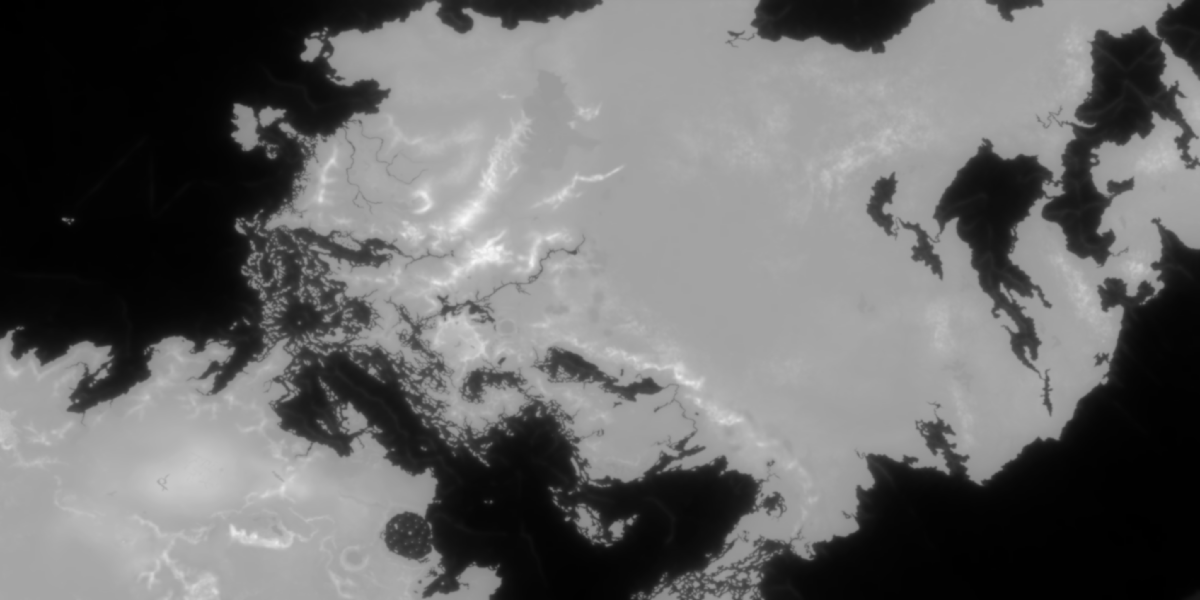

In [98]:
def func(x, parameter):
    return 1/(1+np.exp(-parameter*float(x-128)))

parameter = 0.018

erodedData = np.multiply(fullHeightmap,np.vectorize(func)(diffused, parameter)).astype(np.uint8)
lims = np.min(erodedData[imData==0]), np.max(erodedData[imData==0]), np.min(erodedData[imData!=0]), np.max(erodedData[imData!=0])
def func(x, y, a, b, c, d):
    if y==0:
        return 127*((x-a)/(b-a))
    else:
        return 128+127*((x-c)/(d-c))**2
erodedData = np.round(np.vectorize(func)(erodedData, imData, lims[0],lims[1],lims[2],lims[3])).astype(np.uint8)
blur_radius = [2,3,4]
temp = sum([ndimage.gaussian_filter(erodedData, sigma=r)/len(blur_radius) for r in blur_radius])
erodedData = np.round(temp).astype(np.uint8)
display(Image.fromarray(erodedData).resize((1200,600), Image.Resampling.NEAREST))
Image.fromarray(erodedData).save('output files/step5.png')

## Watercolor

In [4]:
# If importing map with bathymetry (0-127 water, 128-255 land)
erodedData = np.array(Image.open(r"input files/bathymetry.png","r").convert('L'))#.resize((1200,600), Image.Resampling.NEAREST))

  0%|          | 0/4096 [00:00<?, ?it/s]

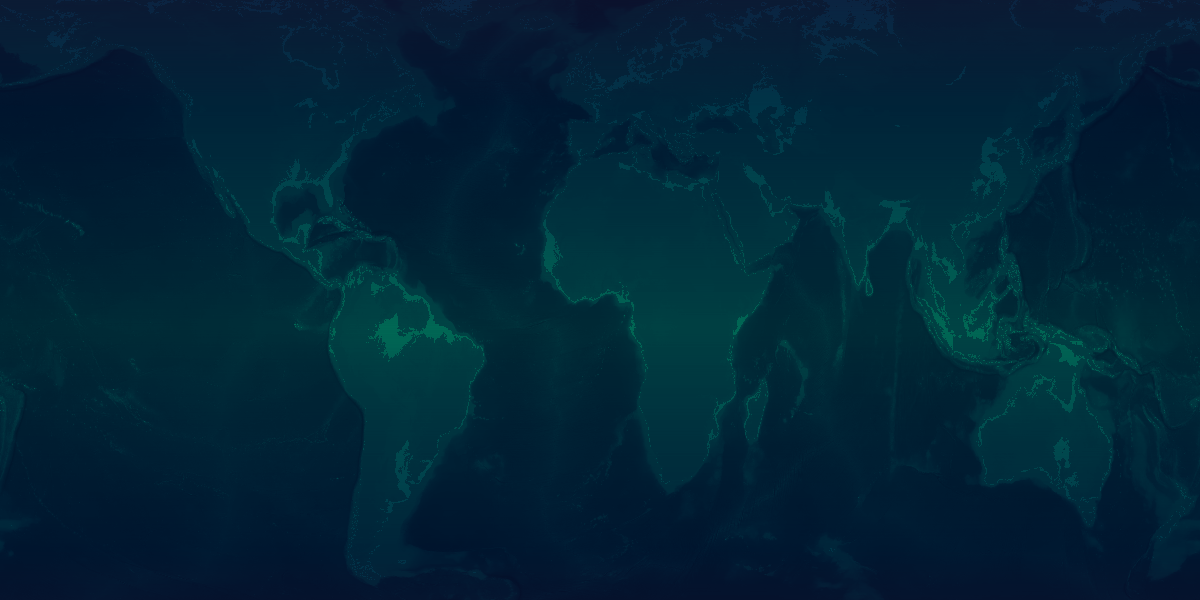

Remember to convert it to dds


In [5]:
def inner_loop(y0,erodedData,waterlims,landlims,northLat,temperate_center,artic_center,intermediate,m):
    temp2 = []
    equator_distance = abs(m*(y0/erodedData.shape[0])+northLat)+np.random.random()*0.01 #0 if at equator, northlat if at the poles 
    for x0 in range(erodedData.shape[1]):
        height = erodedData[y0,x0]
        
        if height>=128: height = 255-min(height,135)
        if True:#height<128:
            # Sea
            height = height if height<waterlims[3] else waterlims[3]
            equatormodifier = (1-equator_distance*0.7)**2
            if equator_distance<intermediate: 
                red = 0
            else:
                red = int(20*(equator_distance-intermediate)/(0.5-intermediate))

            mingB = 0.73-0.17*equator_distance/0.5
            max1gB = 1
            max2gB = 1.25-0.25*(equator_distance/0.5)
            minmod = 60-18*equator_distance/0.5
            max1mod = 97-28*equator_distance/0.5
            max2mod = 135-50*(equator_distance/0.5)

            if height<=waterlims[1]:
                modifier = ((height-waterlims[0])/(waterlims[1]-waterlims[0]))**2*0.5
                heightmod = minmod+(max1mod-minmod)*modifier
                gb = mingB+(max1gB-mingB)*modifier
            elif height<=waterlims[2]:
                modifier = ((height-waterlims[1])/(waterlims[2]-waterlims[1]))*0.5+0.5
                heightmod = minmod+(max1mod-minmod)*modifier
                gb = mingB+(max1gB-mingB)*modifier
            else:
                modifier = ((height-waterlims[2])/(waterlims[3]-waterlims[2]))
                heightmod = max1mod+(max2mod-max1mod)*modifier
                gb = max1gB+(max2gB-max1gB)*modifier
            
            blue = int(np.sqrt((heightmod**2-red**2)/(gb**2+1)))
            green = int(gb*blue*equatormodifier)
        # else:
        #     # Land
        #     height = height if height>landlims[0]+1 else landlims[0]+1
        #     height = height if height<landlims[1] else landlims[1]
        #     if equator_distance<artic_center: 
        #         red = int(50*(artic_center-equator_distance)/artic_center)
        #     else:
        #         red = 0
        #     if equator_distance<=temperate_center:
        #         temp = equator_distance/temperate_center
        #         blue = 0
        #         minmod = 56
        #     else:
        #         temp = (equator_distance-temperate_center)/(0.5-temperate_center)
        #         blue = 74*temp
        #         minmod = 56+35*temp
            
        #     maxmod = 77+49*equator_distance/0.5

        #     modifier = ((height-landlims[0])/(landlims[1]-landlims[0]))**0.5
        #     heightmod = minmod+(maxmod-minmod)*modifier
        #     green = int(np.sqrt(heightmod**2-blue**2-red**2))
        #     blue = int(blue)
        temp2.append([red, green, blue])
    return temp2

equator = 0.547 #If 0 is the top, 1 the bottom, where is the equator in your map? The equation for m works with equator = 0, 0.5 or 1. ABW -> 0.547
northLat = 0.389 #0.5 if the northernmost part of the image is the north pole. In ABW for example, the top of the image is at 70 degrees of latitude, so 70/90*0.5 = 0.389
temperate_center = 0.187 #If 0 is the equator, 0.5 the north pole. You want this between Gibraltar and the Pirinees, or equivalent in your mod. ABW -> 0.187
artic_center = 0.33 #If 0 is the equator, 0.5 the north pole. You want this around Helsinki in Finland, or equivalent in your mod. ABW -> 0.33

temp = np.mean(erodedData[erodedData<128]), np.std(erodedData[erodedData<128])
waterlims = np.min(erodedData[erodedData<128]), np.percentile(erodedData[erodedData<128],80), np.percentile(erodedData[erodedData<128],96),min(np.max(erodedData[erodedData<128]),127)
temp = np.mean(erodedData[erodedData>127]), np.std(erodedData[erodedData>127])
landlims = max(np.min(erodedData[erodedData>127]),128),np.max(erodedData[erodedData>127])

m = -northLat/equator if equator != 0 else -1
intermediate = (artic_center+temperate_center)/2
watercolor = np.stack((erodedData.copy(),)*3, axis=-1)

result = Parallel(n_jobs=-2)(delayed(inner_loop)(y0,erodedData,waterlims,landlims,northLat,temperate_center,artic_center,intermediate,m) for y0 in tqdm(range(erodedData.shape[0])))

for y0, res in enumerate(result):
    for x0, value in enumerate(res):
        watercolor[y0,x0,:] = value

    
display(Image.fromarray(watercolor).resize((1200,600), Image.Resampling.NEAREST))
Image.fromarray(watercolor).save('output files/watercolor_rgb_waterspec_a.png')
print('Remember to convert it to dds')